In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import kruskal

In [24]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes/Pancancer.tsv"
GENE_EXP_DATA = "../data/datasets/PCAWG/gene_expression/tophat_star_fpkm.v2_aliquot_gl.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
ID_MAP = "../data/datasets/PCAWG/misc/tumor_id_mappings.tsv"
GENE_NAME_MAP = "../data/ref/gene_mappings.tsv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files
RESULTS_DIR = "../results/PCAWG"
os.makedirs(RESULTS_DIR, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/gene_expression"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)
    
CANCER_TYPES = os.listdir(ANNOTATED_MUTATIONS)
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

37 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Lymph-NOS', 'Myeloid-MPN', 'Cervix-AdenoCA', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Bone-Cart', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Epith', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Breast-DCIS', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Myeloid-MDS', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [25]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [26]:
pancan_driver_genes = pd.read_csv(DRIVER_GENES, sep="\t")
pancan_driver_genes = pancan_driver_genes[["gene", "gene_length"]]
print(pancan_driver_genes.shape)
driver_genes_list = pancan_driver_genes["gene"].tolist()

(15, 2)


In [27]:
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	mut_cancer_df = mut_cancer_df[mut_cancer_df["gene"].isin(driver_genes_list)]
	mut_cancer_df["cancer_type"] = cancer_type
	mut_df = pd.concat([mut_df, mut_cancer_df], ignore_index=True)
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4018283613.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4018283613.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4018283613.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4018283613.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd

(122031, 14)


In [28]:
print(mut_df["Variant_Classification"].unique().tolist())
nmd_mutations = ["Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins"]
mut_df["nmd_mut"] = mut_df["Variant_Classification"].isin(nmd_mutations)
mut_df["has_nmd_mut"] = mut_df.groupby(["Tumor_Sample_Barcode", "gene"])["nmd_mut"].transform("max")
mut_df = mut_df[~mut_df["has_nmd_mut"]]
print(mut_df.shape)

['Intron', 'Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site', "5'Flank", 'Frame_Shift_Del', "5'UTR", "3'UTR", 'Silent', 'Frame_Shift_Ins', 'In_Frame_Del', 'IGR', 'De_novo_Start_InFrame', 'In_Frame_Ins', 'Nonstop_Mutation', 'De_novo_Start_OutOfFrame']
(90183, 16)


In [29]:
sample_gene_df = mut_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver", "cancer_type"]).size().reset_index(name="mutation_count")
sample_gene_df.drop_duplicates(inplace=True)
print(sample_gene_df.shape)
sample_gene_df = pd.merge(sample_gene_df, pancan_driver_genes, on="gene", how="left")
bins = [0, 50000, 500000, sample_gene_df["gene_length"].max()]
labels = ["<50kb", "50-500kb", ">500kb"]
sample_gene_df["gene_length_group"] = pd.cut(sample_gene_df["gene_length"], bins=bins, labels=labels, include_lowest=True)
sample_gene_df["gene_size_group"] = pd.qcut(sample_gene_df["gene_length"], q=3, labels=["Q1", "Q2", "Q3"])
print(sample_gene_df.shape)

(10169, 5)
(10169, 8)


In [30]:
# get rna-seq id corresponding to tumor sample id 
id_map_df = pd.read_csv(ID_MAP, sep="\t")
id_map_df = id_map_df[["tumor_wgs_aliquot_id", "tumor_rna_seq_aliquot_id"]]
id_map_df.rename(columns={"tumor_wgs_aliquot_id": "Tumor_Sample_Barcode"}, inplace=True)
id_map_df.drop_duplicates(inplace=True)
print(id_map_df.shape)
id_map_df.dropna(inplace=True)
print(id_map_df.shape)

(2834, 2)
(1284, 2)


In [31]:
# get gene expression data for tumor samples in cancer type
gene_exp_df = pd.read_csv(GENE_EXP_DATA, sep="\t", index_col=0).T.reset_index()
gene_exp_df.rename({"index": "tumor_rna_seq_aliquot_id"}, axis=1, inplace=True)
gene_exp_df.set_index("tumor_rna_seq_aliquot_id", inplace=True)
# normalize expression values for each gene
gene_exp_df = gene_exp_df.transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.5, axis=0)
# gene_exp_df = gene_exp_df.transform(lambda x: (x - x.mean()) / (x.std()) if x.std() > 0 else 0, axis=0)
gene_exp_df = gene_exp_df.reset_index()
print(gene_exp_df.shape)
gene_exp_df = gene_exp_df.merge(id_map_df, on="tumor_rna_seq_aliquot_id", how="inner")
print(gene_exp_df.shape)
tumor_list = gene_exp_df["Tumor_Sample_Barcode"].unique().tolist()
gene_exp_df = gene_exp_df[gene_exp_df["Tumor_Sample_Barcode"].isin(tumor_list)]
print(gene_exp_df["Tumor_Sample_Barcode"].nunique())

(1521, 57821)
(1267, 57822)
1267


In [32]:
# get gene name mapping from ensembl gene id to hgnc symbol
gene_name_map_df = pd.read_csv(GENE_NAME_MAP, sep="\t")
gene_name_map_df = gene_name_map_df[["ensembl_gene_id", "hgnc_symbol"]]
print(gene_name_map_df.shape)
gene_name_map_df.dropna(inplace=True)
print(gene_name_map_df.shape)
gene_name_map_df.drop_duplicates(inplace=True)
print(gene_name_map_df.shape)
gene_name_map = dict(zip(gene_name_map_df["ensembl_gene_id"], gene_name_map_df["hgnc_symbol"]))
print(len(gene_name_map), list(gene_name_map.items())[:5])

# rename columns
gene_exp_df.columns = gene_exp_df.columns.str.split(".").str[0]
gene_exp_df.rename(columns=gene_name_map, inplace=True)

# only keep data for driver genes and tumor sample id
gene_exp_df = gene_exp_df[gene_exp_df.columns.intersection(driver_genes_list + ["Tumor_Sample_Barcode"])]
print(gene_exp_df.shape)

(278276, 2)
(241392, 2)
(46525, 2)
46522 [('ENSG00000210049', 'MT-TF'), ('ENSG00000211459', 'MT-RNR1'), ('ENSG00000210077', 'MT-TV'), ('ENSG00000210082', 'MT-RNR2'), ('ENSG00000209082', 'MT-TL1')]
(1267, 16)


In [33]:
# add gene expression data to mutation data
print(sample_gene_df.shape)
tumor_gene_exp = sample_gene_df.merge(gene_exp_df, on="Tumor_Sample_Barcode", how="left")
tumor_gene_exp["gene_exp"] = tumor_gene_exp.apply(lambda x: x[x["gene"]], axis=1)
tumor_gene_exp = tumor_gene_exp[["Tumor_Sample_Barcode", "gene", "gene_exp", "has_driver", "cancer_type", "mutation_count", "gene_length_group", "gene_length", "gene_size_group"]]
print(tumor_gene_exp.shape)
# remove samples which do not have gene expression data
tumor_gene_exp = tumor_gene_exp[~tumor_gene_exp["gene_exp"].isnull()]
print(tumor_gene_exp.shape)
tumor_gene_exp["has_driver"] = tumor_gene_exp["has_driver"].apply(lambda x: "Driver mutation" if x else "Only passenger mutations")

(10169, 8)
(10169, 9)
(5068, 9)


In [34]:
# add gene expression data for driver genes which are not mutated in a tumor sample
tumor_list = tumor_gene_exp["Tumor_Sample_Barcode"].unique().tolist()
for tumor in tumor_list:
    cancer_type = tumor_gene_exp[tumor_gene_exp["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
    for gene in driver_genes_list:
        gene_length_group = tumor_gene_exp[tumor_gene_exp["gene"] == gene]["gene_length_group"].values[0]
        gene_size_group = tumor_gene_exp[tumor_gene_exp["gene"] == gene]["gene_size_group"].values[0]
        if gene not in tumor_gene_exp[tumor_gene_exp["Tumor_Sample_Barcode"] == tumor]["gene"].tolist():
            exp_data = pd.DataFrame([{
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "has_driver": "No mutations",
                "gene_exp": gene_exp_df[gene_exp_df["Tumor_Sample_Barcode"] == tumor][gene].values[0],
                "mutation_count": 0,
                "cancer_type": cancer_type,
                "gene_length_group": gene_length_group,
                "gene_size_group": gene_size_group
            }])
            tumor_gene_exp = pd.concat([tumor_gene_exp, exp_data], axis=0)
print(tumor_gene_exp.shape)

(17295, 9)


In [35]:
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
print(cancer_gene_type.shape)
cancer_gene_type = cancer_gene_type[cancer_gene_type["Hugo Symbol"].isin(driver_genes_list)]
print(cancer_gene_type.shape)
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)

(1154, 3)
(14, 3)


In [36]:
tumor_gene_exp["cancer_gene_type"] = tumor_gene_exp["gene"].apply(lambda x: cancer_gene_type[cancer_gene_type["Hugo Symbol"] == x]["type"].values[0] if x in cancer_gene_type["Hugo Symbol"].tolist() else "Unknown")
print(tumor_gene_exp.shape)
tumor_gene_exp = tumor_gene_exp[tumor_gene_exp["cancer_gene_type"] != "Unknown"]
print(tumor_gene_exp.shape)
tumor_gene_exp = tumor_gene_exp[tumor_gene_exp["has_driver"] != "Both"]
print(tumor_gene_exp.shape)

(17295, 10)
(16142, 10)
(16142, 10)


In [37]:
tumor_gene_exp["mutation_count_bin"] = pd.cut(
    tumor_gene_exp["mutation_count"], 
    bins=[-1, 0, 1, 2, 5, 10, 20, 1000], 
    labels=["0", "1", "2", "3-5", "5-10", "10-20", "20+"]
)

In [38]:
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")[["Tumor_Sample_Barcode", "total_mutations"]]
tumor_gene_exp = pd.merge(tumor_gene_exp, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
tumor_gene_exp["TMB"] = tumor_gene_exp["total_mutations"] * 1e6 / (3.2 * 1e9) # mutations/Mb for 3.2 Gb genome size
tumor_gene_exp["TMB_group"] = pd.cut(tumor_gene_exp["TMB"], bins=[0, 5, 10, np.inf], labels=["Low (0-5/Mb)", "Medium (5-10/Mb)", "High (>=10/Mb)"])

In [39]:
# make groups for each mutation count bin
tsg_data = tumor_gene_exp[tumor_gene_exp["cancer_gene_type"] == "TSG"]
tsg_groups = tsg_data.groupby("mutation_count_bin")["gene_exp"].apply(list).to_dict()
stat_tsg, p_tsg = kruskal(*tsg_groups.values())
print(f"Kruskal-Wallis test for TSG: {stat_tsg}, p-value: {p_tsg}")

og_data = tumor_gene_exp[tumor_gene_exp["cancer_gene_type"] == "OG"]
og_groups = og_data.groupby("mutation_count_bin")["gene_exp"].apply(list).to_dict()
stat_og, p_og = kruskal(*og_groups.values())
print(f"Kruskal-Wallis test for OG: {stat_og}, p-value: {p_og}")

Kruskal-Wallis test for TSG: 1628.3536921769976, p-value: 0.0
Kruskal-Wallis test for OG: 14.922042374579068, p-value: 0.02087179334532519


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/1823727777.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tsg_groups = tsg_data.groupby("mutation_count_bin")["gene_exp"].apply(list).to_dict()
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/1823727777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  og_groups = og_data.groupby("mutation_count_bin")["gene_exp"].apply(list).to_dict()


['Only passenger mutations' 'No mutations']


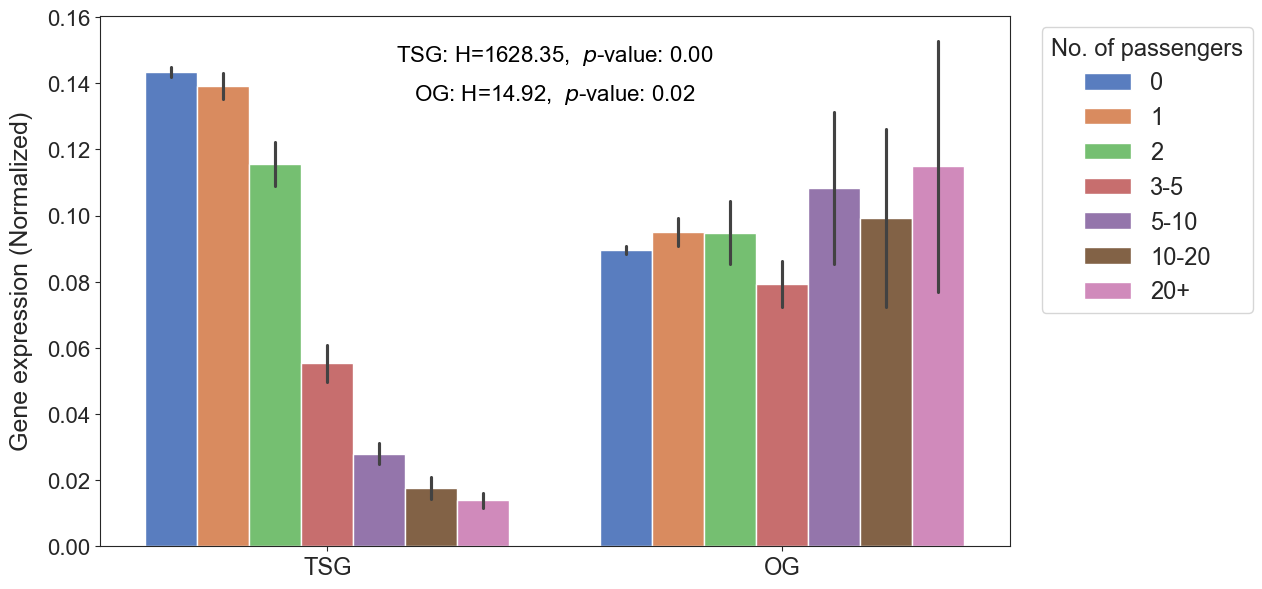

In [40]:
plt.figure(figsize=(13, 6))

plot_df = tumor_gene_exp[tumor_gene_exp["has_driver"] != "Driver mutation"]
print(plot_df["has_driver"].unique())

hue_order = ["0", "1", "2", "3-5", "5-10", "10-20", "20+"]

ax = sns.barplot(
    x="cancer_gene_type",
    y="gene_exp",
    hue="mutation_count_bin",
    hue_order=hue_order,
    data=plot_df,
    errorbar='se',
    palette="muted"
)

# add kruskal-wallis test annotations
plt.text(0.5, 0.145, rf"TSG: H={stat_tsg:.2f},  $\it{{p}}$-value: {p_tsg:.2f}", ha="center", va="bottom", fontsize=16, color="black")
plt.text(0.5, 0.133, rf"OG: H={stat_og:.2f},  $\it{{p}}$-value: {p_og:.2f}", ha="center", va="bottom", fontsize=16, color="black")

plt.xticks(fontsize=17)
plt.xlabel("")
plt.yticks(fontsize=16)
plt.ylabel("Gene expression (Normalized)", fontsize=18, labelpad=10)
plt.legend(title="No. of passengers", fontsize=17, title_fontsize=17, loc="upper right", bbox_to_anchor=(1.28, 1))
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gene_expression_by_passenger_count.png", dpi=300)

# source data
plot_df[["cancer_gene_type", "mutation_count_bin", "gene_exp"]].to_csv(f"{PLOT_DATA_DIR}/gene_expression_by_passenger_count.tsv", sep="\t", index=False)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4263536257.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4263536257.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4263536257.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


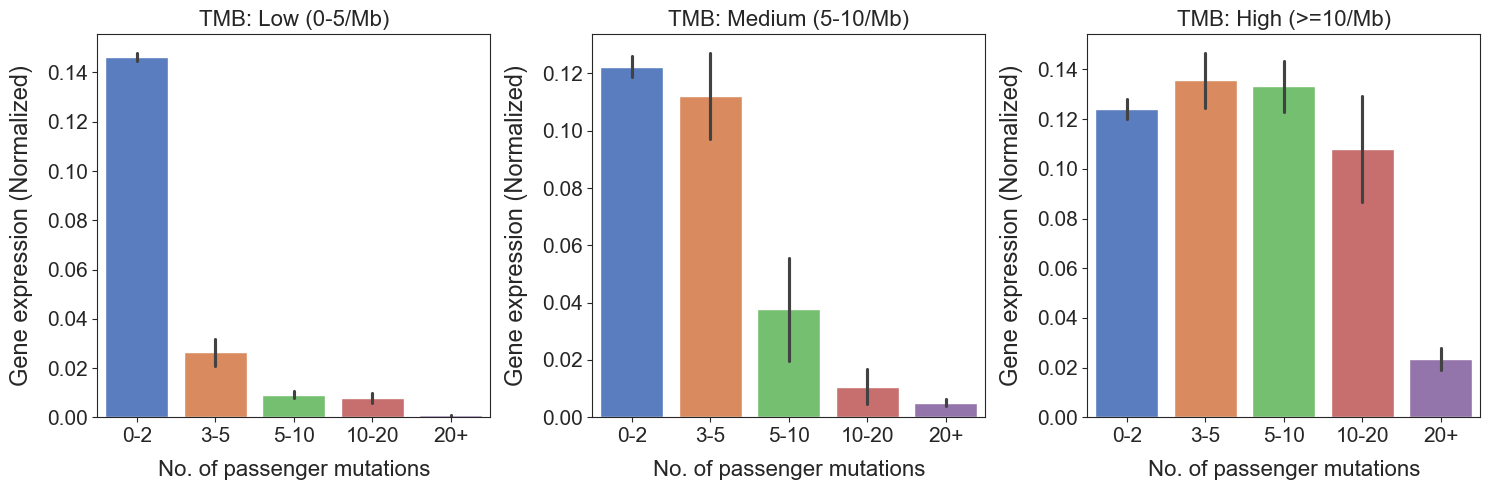

In [41]:
# make subplots for each TMB group
tmb_groups = ["Low (0-5/Mb)", "Medium (5-10/Mb)", "High (>=10/Mb)"]

plot_df = tumor_gene_exp[tumor_gene_exp["has_driver"] != "Driver mutation"]
plot_df = plot_df[plot_df["cancer_gene_type"] == "TSG"]
plot_df["mutation_count_bin"] = pd.cut(
    plot_df["mutation_count"], 
    bins=[-1, 2, 5, 10, 20, 1000], 
    labels=["0-2", "3-5", "5-10", "10-20", "20+"]
)

plt.subplots(figsize=(15, 5), ncols=len(tmb_groups), nrows=1)
for i, tmb_group in enumerate(tmb_groups):
    plt.subplot(1, len(tmb_groups), i + 1)
    sns.set_style("ticks")
    sns.barplot(
        x="mutation_count_bin",
        y="gene_exp",
        data=plot_df[plot_df["TMB_group"] == tmb_group],
        errorbar='se',
        palette="muted",
    )
    plt.title(f"TMB: {tmb_group}", fontsize=16)
    plt.xticks(fontsize=15)
    plt.xlabel("No. of passenger mutations", fontsize=16, labelpad=10)
    plt.yticks(fontsize=15)
    plt.ylabel("Gene expression (Normalized)", fontsize=17, labelpad=10)
    plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gene_expression_by_passenger_count_TMB_subplots.png", dpi=300)

# source data
plot_df[["cancer_gene_type", "mutation_count_bin", "gene_exp", "TMB_group"]].to_csv(f"{PLOT_DATA_DIR}/gene_expression_by_passenger_count_TMB_subplots.tsv", sep="\t", index=False)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4284579709.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4284579709.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/4284579709.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


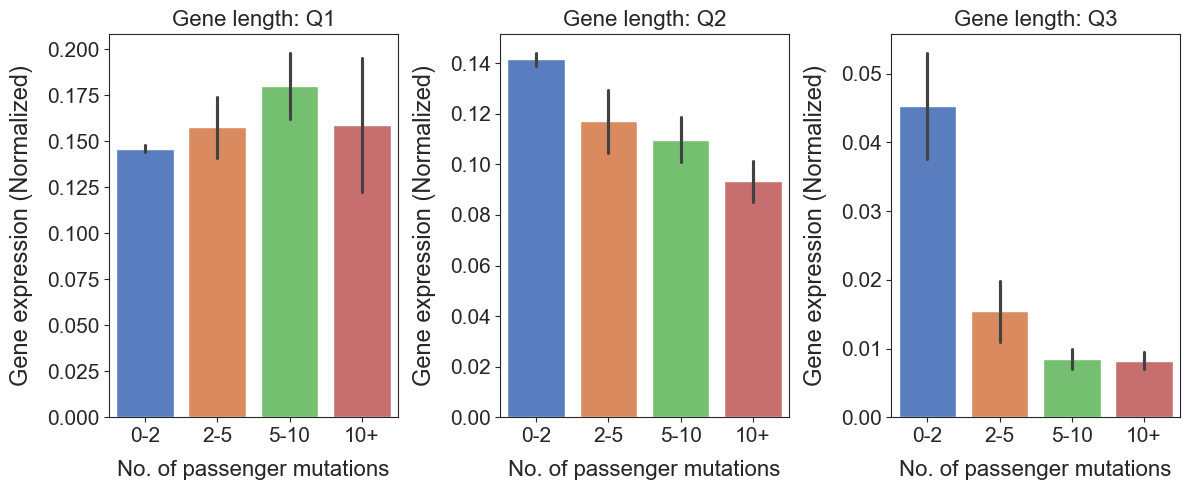

In [42]:
# make subplots for each gene length quartile
gene_length_groups = plot_df["gene_size_group"].unique().tolist()
gene_length_groups.sort()

# bins=[-1, 0, 1, 2, 5, 10, 20, 1000], 
# labels=["0", "1", "2", "3-5", "5-10", "10-20", "20+"]

plot_df = tumor_gene_exp[tumor_gene_exp["has_driver"] != "Driver mutation"]
plot_df = plot_df[plot_df["cancer_gene_type"] == "TSG"]
plot_df["mutation_count_bin"] = pd.cut(
    plot_df["mutation_count"], 
    bins=[-1, 2, 5, 10, 1000], 
    labels=["0-2", "2-5", "5-10", "10+"]
)

plt.subplots(figsize=(12, 5), ncols=len(gene_length_groups), nrows=1)
for i, q_group in enumerate(gene_length_groups):
    plt.subplot(1, len(gene_length_groups), i + 1)
    sns.set_style("ticks")
    sns.barplot(
        x="mutation_count_bin",
        y="gene_exp",
        data=plot_df[plot_df["gene_size_group"] == gene_length_groups[i]],
        errorbar='se',
        palette="muted",
    )
    plt.title(f"Gene length: {gene_length_groups[i]}", fontsize=16)
    plt.xticks(fontsize=15)
    plt.xlabel("No. of passenger mutations", fontsize=16, labelpad=10)
    plt.yticks(fontsize=15)
    plt.ylabel("Gene expression (Normalized)", fontsize=17, labelpad=10)
    plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gene_expression_by_passenger_count_gene_length_quartile_subplots.png", dpi=300)

# source data
plot_df[["cancer_gene_type", "mutation_count_bin", "gene_exp", "gene_size_group"]].to_csv(f"{PLOT_DATA_DIR}/gene_expression_by_passenger_count_gene_length_quartile_subplots.tsv", sep="\t", index=False)

In [43]:
plot_df = tumor_gene_exp[(tumor_gene_exp["has_driver"] != "Driver mutation") & (tumor_gene_exp["cancer_gene_type"] == "TSG")]
tumor_gene_exp_tsg_means = plot_df.groupby(["mutation_count_bin"])["gene_exp"].mean().reset_index()
exp_without_mutations = tumor_gene_exp_tsg_means[tumor_gene_exp_tsg_means["mutation_count_bin"] == "0"]["gene_exp"].values[0]
print(exp_without_mutations)
tumor_gene_exp_tsg_means["fold_change"] = exp_without_mutations / tumor_gene_exp_tsg_means["gene_exp"]
tumor_gene_exp_tsg_means

0.1434013575649385


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/253037768.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tumor_gene_exp_tsg_means = plot_df.groupby(["mutation_count_bin"])["gene_exp"].mean().reset_index()


,mutation_count_bin,gene_exp,fold_change
0,0,0.143401,1.000000
1,1,0.139297,1.029468
2,2,0.115606,1.240437
3,3-5,0.055288,2.593710
4,5-10,0.028032,5.115639
5,10-20,0.017691,8.106006
6,20+,0.013883,10.329624


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TSG_No mutations vs. TSG_Only passenger mutations: Mann-Whitney-Wilcoxon test greater, P_val:2.743e-152 U_stat=1.045e+07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OG_No mutations vs. OG_Only passenger mutations: Mann-Whitney-Wilcoxon test smaller, P_val:6.686e-03 U_stat=2.375e+06


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99502/3775325151.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.boxplot(


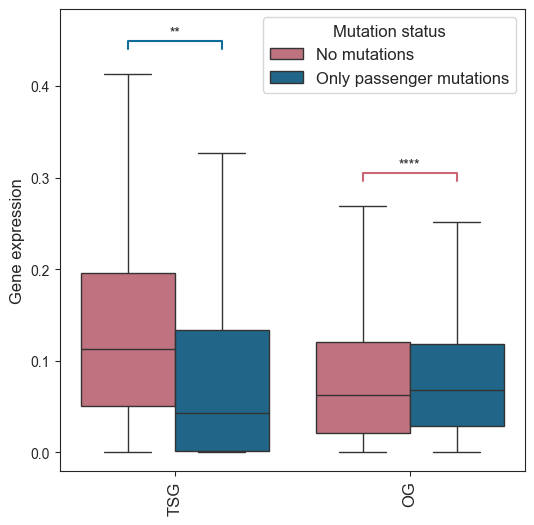

In [44]:
plt.figure(figsize=(6, 6))
# color palette
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
hue_order = ["No mutations", "Only passenger mutations"]

ax = sns.boxplot(
    x="cancer_gene_type",
    y="gene_exp",
    hue="has_driver",
	hue_order=hue_order,
    data=tumor_gene_exp,
    showfliers=False,
	palette=cmap,
)

# add p-value annotation
pairs = []
for gene_type in ["OG", "TSG"]:
    pairs.append(((gene_type, "No mutations"), (gene_type, "Only passenger mutations")))
    
annotator = Annotator(
    ax, 
    pairs, 
    x="cancer_gene_type",
    y="gene_exp",
    hue="has_driver",
    data=tumor_gene_exp,
    hue_order=hue_order,
	order=["OG", "TSG"],
)

annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='inside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='inside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

plt.xticks(rotation=90, fontsize=12)
plt.xlabel("")
plt.ylabel("Gene expression", fontsize=12)
plt.legend(title="Mutation status", fontsize=12, title_fontsize=12, loc="upper right")